# Fully-Connected Neural Nets
In the previous homework you implemented a fully-connected two-layer neural network on CIFAR-10. The implementation was simple but not very modular since the loss and gradient were computed in a single monolithic function. This is manageable for a simple two-layer network, but would become impractical as we move to bigger models. Ideally we want to build networks using a more modular design so that we can implement different layer types in isolation and then snap them together into models with different architectures.

In this exercise we will implement fully-connected networks using a more modular approach. For each layer we will implement a `forward` and a `backward` function. The `forward` function will receive inputs, weights, and other parameters and will return both an output and a `cache` object storing data needed for the backward pass, like this:

```python
def layer_forward(x, w):
  """ Receive inputs x and weights w """
  # Do some computations ...
  z = # ... some intermediate value
  # Do some more computations ...
  out = # the output
   
  cache = (x, w, z, out) # Values we need to compute gradients
   
  return out, cache
```

The backward pass will receive upstream derivatives and the `cache` object, and will return gradients with respect to the inputs and weights, like this:

```python
def layer_backward(dout, cache):
  """
  Receive dout (derivative of loss with respect to outputs) and cache,
  and compute derivative with respect to inputs.
  """
  # Unpack cache values
  x, w, z, out = cache
  
  # Use values in cache to compute derivatives
  dx = # Derivative of loss with respect to x
  dw = # Derivative of loss with respect to w
  
  return dx, dw
```

After implementing a bunch of layers this way, we will be able to easily combine them to build classifiers with different architectures.

In addition to implementing fully-connected networks of arbitrary depth, we will also explore different update rules for optimization, and introduce Dropout as a regularizer and Batch/Layer Normalization as a tool to more efficiently optimize deep networks.
  

In [3]:
# As usual, a bit of setup
from __future__ import print_function
import time
import numpy as np
import matplotlib.pyplot as plt
from cs231n.classifiers.fc_net import *
from cs231n.data_utils import get_CIFAR10_data
from cs231n.gradient_check import eval_numerical_gradient, eval_numerical_gradient_array
from cs231n.solver import Solver

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

def rel_error(x, y):
  """ returns relative error """
  return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# Load the (preprocessed) CIFAR10 data.

data = get_CIFAR10_data()
for k, v in list(data.items()):
  print(('%s: ' % k, v.shape))

('y_train: ', (49000,))
('y_test: ', (1000,))
('X_train: ', (49000, 3, 32, 32))
('X_test: ', (1000, 3, 32, 32))
('y_val: ', (1000,))
('X_val: ', (1000, 3, 32, 32))


# Affine layer: foward
Open the file `cs231n/layers.py` and implement the `affine_forward` function.

Once you are done you can test your implementaion by running the following:

In [4]:
# Test the affine_forward function

num_inputs = 2
input_shape = (4, 5, 6)
output_dim = 3

input_size = num_inputs * np.prod(input_shape)
weight_size = output_dim * np.prod(input_shape)

x = np.linspace(-0.1, 0.5, num=input_size).reshape(num_inputs, *input_shape)
w = np.linspace(-0.2, 0.3, num=weight_size).reshape(np.prod(input_shape), output_dim)
b = np.linspace(-0.3, 0.1, num=output_dim)

out, _ = affine_forward(x, w, b)
correct_out = np.array([[ 1.49834967,  1.70660132,  1.91485297],
                        [ 3.25553199,  3.5141327,   3.77273342]])

# Compare your output with ours. The error should be around e-9 or less.
print('Testing affine_forward function:')
print('difference: ', rel_error(out, correct_out))

Testing affine_forward function:
difference:  9.769847728806635e-10


In [5]:
print("w.shape:   ", w.shape)
print("x.shape:   ", x.shape)
print("b.shape:   ", b.shape)
print("correct_out.shape: ", correct_out.shape)
print("out.shape: ", out.shape)

"""
w.shape:    (120, 3)
x.shape:    (2, 4, 5, 6)
b.shape:    (3,)
out.shape:  (2,3)
correct_out.shape:
            (2,3)
"""
None

w.shape:    (120, 3)
x.shape:    (2, 4, 5, 6)
b.shape:    (3,)
correct_out.shape:  (2, 3)
out.shape:  (2, 3)


# Affine layer: backward
Now implement the `affine_backward` function and test your implementation using numeric gradient checking.

In [6]:
# Test the affine_backward function
np.random.seed(231)
x = np.random.randn(10, 2, 3)
w = np.random.randn(6, 5)
b = np.random.randn(5)
dout = np.random.randn(10, 5)

dx_num = eval_numerical_gradient_array(lambda x: affine_forward(x, w, b)[0], x, dout)
dw_num = eval_numerical_gradient_array(lambda w: affine_forward(x, w, b)[0], w, dout)
db_num = eval_numerical_gradient_array(lambda b: affine_forward(x, w, b)[0], b, dout)

_, cache = affine_forward(x, w, b)

dx, dw, db = affine_backward(dout, cache)

# The error should be around e-10 or less
print('Testing affine_backward function:')
print('dx error: ', rel_error(dx_num, dx))
print('dw error: ', rel_error(dw_num, dw))
print('db error: ', rel_error(db_num, db))

Testing affine_backward function:
dx error:  5.399100368651805e-11
dw error:  9.904211865398145e-11
db error:  2.4122867568119087e-11


# ReLU activation: forward
Implement the forward pass for the ReLU activation function in the `relu_forward` function and test your implementation using the following:

In [7]:
# Test the relu_forward function

x = np.linspace(-0.5, 0.5, num=12).reshape(3, 4)

out, _ = relu_forward(x)
correct_out = np.array([[ 0.,          0.,          0.,          0.,        ],
                        [ 0.,          0.,          0.04545455,  0.13636364,],
                        [ 0.22727273,  0.31818182,  0.40909091,  0.5,       ]])

# Compare your output with ours. The error should be on the order of e-8
print('Testing relu_forward function:')
print('difference: ', rel_error(out, correct_out))

Testing relu_forward function:
difference:  4.999999798022158e-08


# ReLU activation: backward
Now implement the backward pass for the ReLU activation function in the `relu_backward` function and test your implementation using numeric gradient checking:

In [8]:
np.random.seed(231)
x = np.random.randn(10, 10)
dout = np.random.randn(*x.shape)

dx_num = eval_numerical_gradient_array(lambda x: relu_forward(x)[0], x, dout)

_, cache = relu_forward(x)
dx = relu_backward(dout, cache)

# The error should be on the order of e-12
print('Testing relu_backward function:')
print('dx error: ', rel_error(dx_num, dx))

Testing relu_backward function:
dx error:  3.2756349136310288e-12


## Inline Question 1: 

We've only asked you to implement ReLU, but there are a number of different activation functions that one could use in neural networks, each with its pros and cons. In particular, an issue commonly seen with activation functions is getting zero (or close to zero) gradient flow during backpropagation. Which of the following activation functions have this problem? If you consider these functions in the one dimensional case, what types of input would lead to this behaviour?
1. Sigmoid
2. ReLU
3. Leaky ReLU

## Answer:
Answer to the first question: Sigmoid is the only function that has this problem.

Answer to the second question:
Inputs very far from zero (if we call the inputs "x",   |x| >> 0 make the derivatives near zero, causing the partial derivative "gradient" to be close to zero).  It's easier to see in the graph; say the input is x=10; the gradient f'(10) == 4.5e-5; very very close to zero.  The same is true for an input of x=-10; f'(-10)==4.5e-5.

![The sigmoid function](https://upload.wikimedia.org/wikipedia/commons/8/88/Logistic-curve.svg)


# "Sandwich" layers
There are some common patterns of layers that are frequently used in neural nets. For example, affine layers are frequently followed by a ReLU nonlinearity. To make these common patterns easy, we define several convenience layers in the file `cs231n/layer_utils.py`.

For now take a look at the `affine_relu_forward` and `affine_relu_backward` functions, and run the following to numerically gradient check the backward pass:

In [9]:
from cs231n.layer_utils import affine_relu_forward, affine_relu_backward
np.random.seed(231)
x = np.random.randn(2, 3, 4)
w = np.random.randn(12, 10)
b = np.random.randn(10)
dout = np.random.randn(2, 10)

out, cache = affine_relu_forward(x, w, b)
dx, dw, db = affine_relu_backward(dout, cache)

dx_num = eval_numerical_gradient_array(lambda x: affine_relu_forward(x, w, b)[0], x, dout)
dw_num = eval_numerical_gradient_array(lambda w: affine_relu_forward(x, w, b)[0], w, dout)
db_num = eval_numerical_gradient_array(lambda b: affine_relu_forward(x, w, b)[0], b, dout)

# Relative error should be around e-10 or less
print('Testing affine_relu_forward and affine_relu_backward:')
print('dx error: ', rel_error(dx_num, dx))
print('dw error: ', rel_error(dw_num, dw))
print('db error: ', rel_error(db_num, db))

Testing affine_relu_forward and affine_relu_backward:
dx error:  6.750562121603446e-11
dw error:  8.162015570444288e-11
db error:  7.826724021458994e-12


# Loss layers: Softmax and SVM
You implemented these loss functions in the last assignment, so we'll give them to you for free here. You should still make sure you understand how they work by looking at the implementations in `cs231n/layers.py`.

You can make sure that the implementations are correct by running the following:

In [10]:
np.random.seed(231)
num_classes, num_inputs = 10, 50
x = 0.001 * np.random.randn(num_inputs, num_classes)
y = np.random.randint(num_classes, size=num_inputs)

dx_num = eval_numerical_gradient(lambda x: svm_loss(x, y)[0], x, verbose=False)
loss, dx = svm_loss(x, y)

# Test svm_loss function. Loss should be around 9 and dx error should be around the order of e-9
print('Testing svm_loss:')
print('loss: ', loss)
print('dx error: ', rel_error(dx_num, dx))

dx_num = eval_numerical_gradient(lambda x: softmax_loss(x, y)[0], x, verbose=False)
loss, dx = softmax_loss(x, y)

# Test softmax_loss function. Loss should be close to 2.3 and dx error should be around e-8
print('\nTesting softmax_loss:')
print('loss: ', loss)
print('dx error: ', rel_error(dx_num, dx))

Testing svm_loss:
loss:  8.999602749096233
dx error:  1.4021566006651672e-09

Testing softmax_loss:
loss:  2.302545844500738
dx error:  9.384673161989355e-09


# Two-layer network
In the previous assignment you implemented a two-layer neural network in a single monolithic class. Now that you have implemented modular versions of the necessary layers, you will reimplement the two layer network using these modular implementations.

Open the file `cs231n/classifiers/fc_net.py` and complete the implementation of the `TwoLayerNet` class. This class will serve as a model for the other networks you will implement in this assignment, so read through it to make sure you understand the API. You can run the cell below to test your implementation.

In [11]:
# Notes on fc_net.py's TwoLayerNet class' API:

'''
    The architecture should be affine - relu - affine - softmax.
    
    
    ********** Solver object **********
        Note that this class does not implement gradient descent; instead, it
    will interact with a separate Solver object that is responsible for running
    optimization.
    ********** Solver object **********    
    
    self.params={}
    self.params['W'] = np.array(
   [[1,2,3, ...     ],
    [4,-5,0,-9.1,...],
   ])
    self.params['b'] = np.array(
   [[...],
    [...],
    .
    .
    .
    ]
    )
    
    

'''
None

In [12]:
np.random.seed(231)
N, D, H, C = 3, 5, 50, 7
X = np.random.randn(N, D)
y = np.random.randint(C, size=N)

std = 1e-3
model = TwoLayerNet(input_dim=D, hidden_dim=H, num_classes=C, weight_scale=std)

print('Testing initialization ... ')
W1_std = abs(model.params['W1'].std() - std)
b1 = model.params['b1']
W2_std = abs(model.params['W2'].std() - std)
b2 = model.params['b2']
assert W1_std < std / 10, 'First layer weights do not seem right'
assert np.all(b1 == 0), 'First layer biases do not seem right'
assert W2_std < std / 10, 'Second layer weights do not seem right'
assert np.all(b2 == 0), 'Second layer biases do not seem right'

print('Testing test-time forward pass ... ')
model.params['W1'] = np.linspace(-0.7, 0.3, num=D*H).reshape(D, H)
model.params['b1'] = np.linspace(-0.1, 0.9, num=H)
model.params['W2'] = np.linspace(-0.3, 0.4, num=H*C).reshape(H, C)
model.params['b2'] = np.linspace(-0.9, 0.1, num=C)
X = np.linspace(-5.5, 4.5, num=N*D).reshape(D, N).T
scores = model.loss(X)
correct_scores = np.asarray(
  [[11.53165108,  12.2917344,   13.05181771,  13.81190102,  14.57198434, 15.33206765,  16.09215096],
   [12.05769098,  12.74614105,  13.43459113,  14.1230412,   14.81149128, 15.49994135,  16.18839143],
   [12.58373087,  13.20054771,  13.81736455,  14.43418138,  15.05099822, 15.66781506,  16.2846319 ]])
scores_diff = np.abs(scores - correct_scores).sum()
assert scores_diff < 1e-6, 'Problem with test-time forward pass'

print('Testing training loss (no regularization)')
y = np.asarray([0, 5, 1])
loss, grads = model.loss(X, y)
correct_loss = 3.4702243556
assert abs(loss - correct_loss) < 1e-10, 'Problem with training-time loss'

model.reg = 1.0
loss, grads = model.loss(X, y)
correct_loss = 26.5948426952
assert abs(loss - correct_loss) < 1e-10, 'Problem with regularization loss'

# Errors should be around e-7 or less
for reg in [0.0, 0.7]:
  print('Running numeric gradient check with reg = ', reg)
  model.reg = reg
  loss, grads = model.loss(X, y)

  for name in sorted(grads):
    f = lambda _: model.loss(X, y)[0]
    grad_num = eval_numerical_gradient(f, model.params[name], verbose=False)
    print('%s relative error: %.2e' % (name, rel_error(grad_num, grads[name])))

Testing initialization ... 
Testing test-time forward pass ... 
Testing training loss (no regularization)
Running numeric gradient check with reg =  0.0
W1 relative error: 1.22e-08
W2 relative error: 3.48e-10
b1 relative error: 6.55e-09
b2 relative error: 4.33e-10
Running numeric gradient check with reg =  0.7
W1 relative error: 8.18e-07
W2 relative error: 2.85e-08
b1 relative error: 1.09e-09
b2 relative error: 7.76e-10


# Solver
In the previous assignment, the logic for training models was coupled to the models themselves. Following a more modular design, for this assignment we have split the logic for training models into a separate class.

Open the file `cs231n/solver.py` and read through it to familiarize yourself with the API. After doing so, use a `Solver` instance to train a `TwoLayerNet` that achieves at least `50%` accuracy on the validation set.

In [13]:
# print(x.shape) # (50,10)
# print(X.shape) # ( 3, 5)

In [14]:
#print(len(data)) # 6
print(data.keys())

dict_keys(['y_train', 'y_test', 'X_train', 'X_test', 'y_val', 'X_val'])


In [15]:
model = TwoLayerNet()
solver = None

##############################################################################
# TODO: Use a Solver instance to train a TwoLayerNet that achieves at least  #
# 50% accuracy on the validation set.                                        #
##############################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

data_names=[k for k in data.keys() if 'test' not in k]
data_dict_4_solver={
    data_name: data[data_name] for data_name in data_names
}
    # ie. 'X_train' : data['X_train']
    #     'X_val'   : data['X_val']
    # "data" was initialized using "get_CIFAR10_data()" near the top of this jupyter notebook
solver = Solver(
    model,
    data_dict_4_solver,
    update_rule='sgd',
    optim_config={
        'learning_rate': 1e-3,
    },
    lr_decay=0.95,
    batch_size=100,
    num_epochs=10,
    print_every=200
)
solver.train()


# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
##############################################################################
#                             END OF YOUR CODE                               #
##############################################################################

(Iteration 1 / 4900) loss: 2.304060
(Epoch 0 / 10) train acc: 0.116000; val_acc: 0.094000
(Iteration 201 / 4900) loss: 1.857390
(Iteration 401 / 4900) loss: 1.420187
(Epoch 1 / 10) train acc: 0.407000; val_acc: 0.422000
(Iteration 601 / 4900) loss: 1.700510
(Iteration 801 / 4900) loss: 1.688361
(Epoch 2 / 10) train acc: 0.497000; val_acc: 0.468000
(Iteration 1001 / 4900) loss: 1.385772
(Iteration 1201 / 4900) loss: 1.641580
(Iteration 1401 / 4900) loss: 1.172536
(Epoch 3 / 10) train acc: 0.490000; val_acc: 0.466000
(Iteration 1601 / 4900) loss: 1.268492
(Iteration 1801 / 4900) loss: 1.395750
(Epoch 4 / 10) train acc: 0.532000; val_acc: 0.497000
(Iteration 2001 / 4900) loss: 1.343165
(Iteration 2201 / 4900) loss: 1.276734
(Iteration 2401 / 4900) loss: 1.352778
(Epoch 5 / 10) train acc: 0.525000; val_acc: 0.475000
(Iteration 2601 / 4900) loss: 1.276361
(Iteration 2801 / 4900) loss: 1.271688
(Epoch 6 / 10) train acc: 0.546000; val_acc: 0.509000
(Iteration 3001 / 4900) loss: 1.304489
(Iter

In [16]:
# Run this cell to visualize training loss and train / val accuracy

plt.subplot(2, 1, 1)
plt.title('Training loss')
plt.plot(solver.loss_history, 'o')
plt.xlabel('Iteration')

plt.subplot(2, 1, 2)
plt.title('Accuracy')
plt.plot(solver.train_acc_history, '-o', label='train')
plt.plot(solver.val_acc_history, '-o', label='val')
plt.plot([0.5] * len(solver.val_acc_history), 'k--')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.gcf().set_size_inches(15, 12)
plt.show()

# Multilayer network
Next you will implement a fully-connected network with an arbitrary number of hidden layers.

Read through the `FullyConnectedNet` class in the file `cs231n/classifiers/fc_net.py`.

Implement the initialization, the forward pass, and the backward pass. For the moment don't worry about implementing dropout or batch/layer normalization; we will add those features soon.

In [17]:
# class "FullyConnectedNet"   's API:
'''
For a network with L layers, the architecture will be:
    {affine - [batch/layer norm] - relu - [dropout]} x (L - 1) - affine - softmax
'''    


'''
This class will also implement
    dropout and
    batch/layer normalization

as options

'''

#

'''
Like in the TwoLayerNet class,

    Learnable parameters are stored in
        the self.params dictionary 
        and will be learned using the Solver class
'''

#

'''

'''

#


'\n\n'

## Initial loss and gradient check

As a sanity check, run the following to check the initial loss and to gradient check the network both with and without regularization. Do the initial losses seem reasonable?

For gradient checking, you should expect to see errors around 1e-7 or less.

In [18]:
np.random.seed(231)
N, D, H1, H2, C = 2, 15, 20, 30, 10
X = np.random.randn(N, D)
y = np.random.randint(C, size=(N,))

for reg in [0, 3.14]:
  print('Running check with reg = ', reg)
  model = FullyConnectedNet([H1, H2], input_dim=D, num_classes=C,
                            reg=reg, weight_scale=5e-2, dtype=np.float64)

  loss, grads = model.loss(X, y)
  print('Initial loss: ', loss)
  
  # Most of the errors should be on the order of e-7 or smaller.   
  # NOTE: It is fine however to see an error for W2 on the order of e-5
  # for the check when reg = 0.0
  for name in sorted(grads):
    f = lambda _: model.loss(X, y)[0]
    grad_num = eval_numerical_gradient(f, model.params[name], verbose=False, h=1e-5)
    print('%s relative error: %.2e' % (name, rel_error(grad_num, grads[name])))

Running check with reg =  0
Initial loss:  2.3004790897684924
W1 relative error: 1.48e-07
W2 relative error: 2.21e-05
W3 relative error: 3.53e-07
b1 relative error: 5.38e-09
b2 relative error: 2.09e-09
b3 relative error: 5.80e-11
Running check with reg =  3.14
Initial loss:  5.940411485412347
W1 relative error: 6.59e-09
W2 relative error: 5.91e-08
W3 relative error: 3.80e-07
b1 relative error: 1.48e-08
b2 relative error: 1.72e-09
b3 relative error: 1.80e-10


In [19]:
model.params.keys() # dict_keys(['b1', 'b3', 'W1', 'W2', 'W3', 'b2'])
model.debug_info.keys() # odict_keys(['b1', 'b3', 'W1', 'W2', 'W3', 'b2'])
for i in range(len([H1, H2]) +1   ):
    print("   (model.params['W{0}']).shape == {1}".format(
        i+1, (model.params['W'+str(i+1)]).shape )
    )
    
"""
Success!

   (model.params['W1']).shape  :(15, 20)
   (model.params['W2']).shape  :(20, 30)
   (model.params['W3']).shape  :(30, 10)

"""
None

   (model.params['W1']).shape == (15, 20)
   (model.params['W2']).shape == (20, 30)
   (model.params['W3']).shape == (30, 10)


As another sanity check, make sure you can overfit a small dataset of 50 images. First we will try a three-layer network with 100 units in each hidden layer. In the following cell, tweak the **learning rate** and **weight initialization scale** to overfit and achieve 100% training accuracy within 20 epochs.

(Iteration 1 / 40) loss: 20.835795
(Epoch 0 / 20) train acc: 0.200000; val_acc: 0.111000
(Epoch 1 / 20) train acc: 0.360000; val_acc: 0.138000
(Epoch 2 / 20) train acc: 0.540000; val_acc: 0.144000
(Epoch 3 / 20) train acc: 0.760000; val_acc: 0.138000
(Epoch 4 / 20) train acc: 0.840000; val_acc: 0.157000
(Epoch 5 / 20) train acc: 0.940000; val_acc: 0.171000
(Iteration 11 / 40) loss: 0.033952
(Epoch 6 / 20) train acc: 0.940000; val_acc: 0.181000
(Epoch 7 / 20) train acc: 0.960000; val_acc: 0.178000
(Epoch 8 / 20) train acc: 0.960000; val_acc: 0.171000
(Epoch 9 / 20) train acc: 0.980000; val_acc: 0.163000
(Epoch 10 / 20) train acc: 0.980000; val_acc: 0.164000
(Iteration 21 / 40) loss: 0.047349
(Epoch 11 / 20) train acc: 1.000000; val_acc: 0.163000
(Epoch 12 / 20) train acc: 1.000000; val_acc: 0.162000
(Epoch 13 / 20) train acc: 1.000000; val_acc: 0.162000
(Epoch 14 / 20) train acc: 1.000000; val_acc: 0.163000
(Epoch 15 / 20) train acc: 1.000000; val_acc: 0.164000
(Iteration 31 / 40) loss:

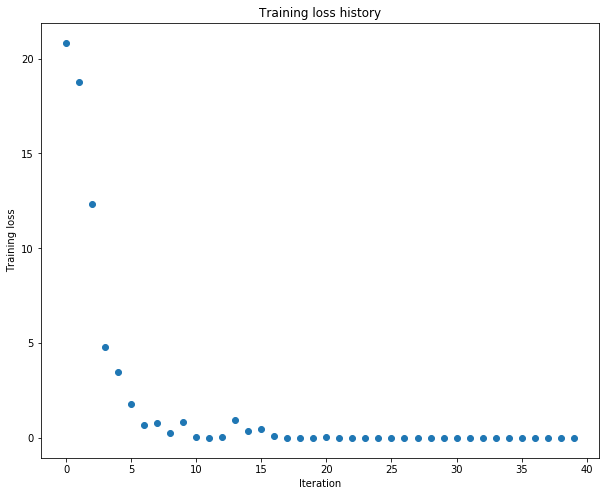

In [20]:
# TODO: Use a three-layer Net to overfit 50 training examples by 
# tweaking just the learning rate and initialization scale.

num_train = 50
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

weight_scale  = 3.872881e-02  #9e-2  # Experiment with this!
learning_rate = 1.956705e-03  #5e-3  # Experiment with this!             # was 1e-4 initially.  1e-3 made the loss at least go down.  1e-2 got us to 100% training accuracy (0.19 val_acc, though; overfitting)

# correct answers someone got:
#weight_scale = 3.862881e-02 #1e-2
#learning_rate = 1.946705e-03 #1e-4

#for weight_scale in weight_scales:
    #for learning_rate in learning_rates:
model = FullyConnectedNet([100, 100],
              weight_scale=weight_scale, dtype=np.float64)
solver = Solver(model, small_data,
                print_every=10, num_epochs=20, batch_size=25,
                update_rule='sgd',
                optim_config={
                  'learning_rate': learning_rate,
                }
         )
solver.train()

plt.plot(solver.loss_history, 'o')
plt.title('Training loss history')
plt.xlabel('Iteration')
plt.ylabel('Training loss')
plt.show()

Now try to use a five-layer network with 100 units on each layer to overfit 50 training examples. Again, you will have to adjust the learning rate and weight initialization scale, but you should be able to achieve 100% training accuracy within 20 epochs.

In [21]:
num_train = 50
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}


In [22]:
#small_data['X_train'].shape # (50, 3, 32, 32)
print(np.max(small_data['X_train'])) #  154.8493469387755
print(np.min(small_data['X_train'])) # -138.557....


154.8493469387755
-138.5578775510204


(Iteration 1 / 40) loss: 2.709880
(Epoch 0 / 20) train acc: 0.060000; val_acc: 0.112000
(Epoch 1 / 20) train acc: 0.120000; val_acc: 0.116000
(Epoch 2 / 20) train acc: 0.220000; val_acc: 0.126000
(Epoch 3 / 20) train acc: 0.320000; val_acc: 0.129000
(Epoch 4 / 20) train acc: 0.320000; val_acc: 0.123000
(Epoch 5 / 20) train acc: 0.420000; val_acc: 0.131000
(Iteration 11 / 40) loss: 1.919742
(Epoch 6 / 20) train acc: 0.440000; val_acc: 0.122000
(Epoch 7 / 20) train acc: 0.480000; val_acc: 0.124000
(Epoch 8 / 20) train acc: 0.560000; val_acc: 0.122000
(Epoch 9 / 20) train acc: 0.540000; val_acc: 0.139000
(Epoch 10 / 20) train acc: 0.600000; val_acc: 0.139000
(Iteration 21 / 40) loss: 1.604761
(Epoch 11 / 20) train acc: 0.640000; val_acc: 0.145000
(Epoch 12 / 20) train acc: 0.640000; val_acc: 0.151000
(Epoch 13 / 20) train acc: 0.640000; val_acc: 0.140000
(Epoch 14 / 20) train acc: 0.680000; val_acc: 0.139000
(Epoch 15 / 20) train acc: 0.680000; val_acc: 0.144000
(Iteration 31 / 40) loss: 

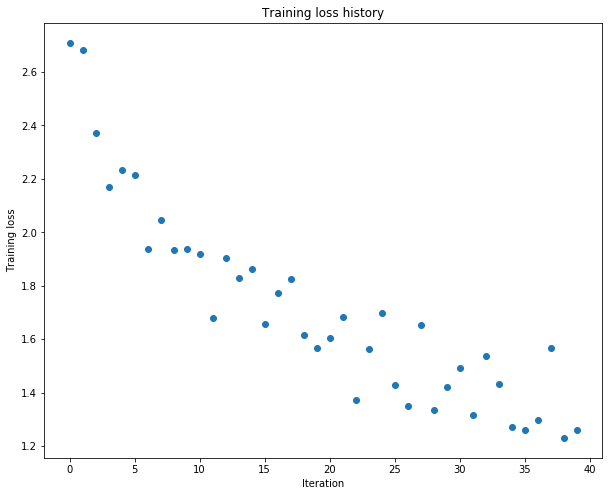

In [23]:
# TODO: Use a five-layer Net to overfit 50 training examples by 
# tweaking just the learning rate and initialization scale.

num_train = 50
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

# best loss so far:      lr          ws
#
#   1.9                 2e-1        1e-2
#
#
#
#
#
#
#

#   the lr was set earlier.
#learning_rate =  3.872881e-02 #5e-3  # Experiment with this!
# learning_rate was initially 2e-3.  I tried 2e-2, which didn't get the loss to 0 in the end.
# Neither did 2e-1
# 2e-0   or (nor did)
# 2e+1   or
# 2e+2     (at this point, the loss is exploding.  lr definitely definitely too high)
# 


#   the weight_scale was set earlier.
#weight_scale  = 3.872881e-02 #8e-1  # Experiment with this!
# "weight_scale" was initially 1e-5.   I tried 1e-2; was this too high?  We got an overflow in numpy.
# 1e-4   loss doesn't go to 0
# 1e-3
#          lr=2e-1  and ws=1e-1   gave us nans repeatedly
#
# combo of lr=2e+0  and ws=1e-2   gave us nans repeatedly.
#          lr=2e+1  and ws=1e-2   also gave repeated nans.
#
#          lr=2e-1  and ws=1e-2   almost worked?
#          lr=2e-1  and ws=1e-3   also sort of works
#
#          lr=9e+1  and ws=1e-5   is TRASH.  It goes up to loss==60
model = FullyConnectedNet([100, 100, 100, 100],
                weight_scale=weight_scale, dtype=np.float64)
solver = Solver(model, small_data,
                print_every=10, num_epochs=20, batch_size=25,
                update_rule='sgd',
                optim_config={
                  'learning_rate': learning_rate,
                }
         )
solver.train()

plt.plot(solver.loss_history, 'o')
plt.title('Training loss history')
plt.xlabel('Iteration')
plt.ylabel('Training loss')
plt.show()

In [24]:
#dir(model) 
'''
['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'bn_params',
 'debug_info',
 'dropout_param',
 'dtype',
 'loss',
 'normalization',
 'num_layers',
 'params',
 'reg',
 'use_dropout']


'''
print(model.params)

import pickle as pkl
fname="model___.pkl"
with open(fname, 'wb') as fp:
    pkl.dump(model, fp)

{'b1': array([[-1.38872861e-07, -2.45071780e-06,  4.67072597e-06,
        -4.52388591e-06, -9.86563267e-07,  3.39368289e-06,
         3.18060906e-06,  5.85717474e-06,  1.42478216e-06,
         2.54848611e-07,  2.58973488e-06, -7.10804338e-07,
        -3.23954736e-06, -1.49349022e-06,  3.65947376e-07,
         3.66875998e-06,  1.09537840e-06, -2.71695715e-06,
        -1.50295524e-06,  2.20162443e-08,  4.77758962e-06,
         1.46796760e-06,  3.56887854e-06,  1.37385902e-06,
        -2.25815238e-06, -2.64074132e-06,  2.81283193e-06,
         2.93446832e-06, -8.48440591e-07, -2.50546322e-06,
        -2.04273161e-06,  2.42593073e-06,  4.38996630e-06,
         3.09535660e-06,  1.09479553e-06,  1.02479826e-06,
         1.49237818e-06, -2.28297226e-06,  3.26651885e-09,
         3.57876938e-06,  2.56155664e-06,  2.15253678e-06,
         2.41071833e-06,  1.59156199e-06, -5.38857392e-07,
         4.54799907e-06,  2.05055678e-06, -1.60126610e-06,
        -7.10005931e-07, -3.13839143e-06,  4.0862

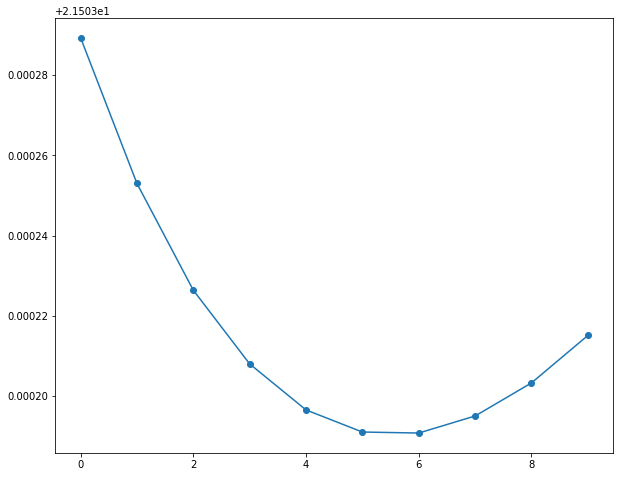

In [25]:
#weight_scale=8e-1   initialized earlier
H=100
model = FullyConnectedNet([H, H, H, H],
                weight_scale=weight_scale, dtype=np.float64)
#print(model.params)

lr=learning_rate
n_iters=10

W1_vals=[]
W2_vals=[]
W3_vals=[]
W4_vals=[]
W5_vals=[]

# training   loop:
for i in range(n_iters):
    # Calculate partial derivatives :
    #      AKA ("grads" or "gradients")
    loss, grads = model.loss(small_data['X_train'], small_data['y_train'])
    
    # gather weights to plot() later:
    W1_vals.append(   np.linalg.norm(model.params['W1'])   )
    W2_vals.append(   np.linalg.norm(model.params['W2'])   )
    W3_vals.append(   np.linalg.norm(model.params['W3'])   )
    W4_vals.append(   np.linalg.norm(model.params['W4'])   )
    W5_vals.append(   np.linalg.norm(model.params['W5'])   )

    #=======================================
    # Update model parameters:
    #=======================================
    
    for param in model.params.keys():
        # Vanilla SGD:
        model.params[param] -= grads[param].reshape(model.params[param].shape)\
                               * lr

X=np.arange(n_iters)
plt.plot(X, W1_vals, '-o', label='W1')
plt.show()
None

In [26]:
len(grads)

# plot:
'''
  1.  np.linalg.norm(weights)   # magnitude(weights)
  2.  Distributions of firing?

  3.  I guess we'll just figure it out, right?
    a.  (Stochastic tinkering)

'''
None

In [27]:
len(model.params)
for key in model.params.keys():
    if key not in grads.keys():
        print("The key in model that's not in grads different key is    ",key)

print(grads.keys())
print(model.params.keys())

dict_keys(['W4', 'b1', 'W3', 'b5', 'b4', 'W2', 'W5', 'b3', 'W1', 'b2'])
dict_keys(['b1', 'W4', 'b2', 'b5', 'b4', 'W2', 'b3', 'W5', 'W1', 'W3'])


In [28]:
#
# Examine the weights one layer at a time,      
#   1 training iteration at a time.
#

In [29]:
# initialize NN:
weight_scale=8e-2
H=100
model = FullyConnectedNet([H, H, H, H],
                weight_scale=weight_scale, dtype=np.float64)
#print(model.params)

lr=learning_rate
n_iters=10

W1_vals=[]
W2_vals=[]
W3_vals=[]
W4_vals=[]
W5_vals=[]

In [30]:
def nathan_norm(X):
    return np.mean(
             np.abs(
               X))

In [31]:
# INITIAL weights
print(nathan_norm(model.params['W1'])) # 0.6387639530754136
print(nathan_norm(model.params['W2'])) # 0.6338071857451346
print(nathan_norm(model.params['W3'])) # 0.6466988766614912
print(nathan_norm(model.params['W4'])) # 0.6411206483383503
print(nathan_norm(model.params['W5'])) # 0.6227080416835916

print(lr)
print(weight_scale)

'''
    0.005      lr
    0.800      weight_scale (Gaussian w/ stdev == 0.8)
'''
None

0.06383414029485315
0.06375788391137134
0.06466740428877699
0.06401304785131788
0.06415227452696286
0.001956705
0.08


In [32]:
print(nathan_norm(grads['W1'])) # 1124.2367713624808
print(nathan_norm(grads['W2'])) # 5708.599205297234
print(nathan_norm(grads['W3'])) # 5488.759530452886
print(nathan_norm(grads['W4'])) # 5091.847740995163
print(nathan_norm(grads['W5'])) #17782.73721538418

0.0028921176474351546
0.014710027704511186
0.012349674872030458
0.010827141489498909
0.034516199177734824


In [33]:
# BAD metric (too small)
#np.linalg.norm( model.params['W1']   ) /    ((model.params['W1']).size)   #0.0014423506255615305
np.linalg.norm( model.params['W1'] , ord=1  ) / ((model.params['W1']).size) # 0.006684215672798174
# I'm not sure what the 1 norm is actually doing.  I'm gonna just use the metric below instead.

0.0006656325694683039

In [34]:
# GOOD measure of the weights (at least, it's one I understand)
np.mean(np.abs(np.random.randn(100)*weight_scale)) # 0.621    for weight_scale=8e-1 (0.8)



0.0638318018890811

In [35]:
#0.8==8e-1 # True

In [36]:
# initialize NN:
#weight_scale=   this was initialized earlier
H=100
model = FullyConnectedNet([H, H, H, H],
                weight_scale=weight_scale, dtype=np.float64)
#print(model.params)

lr=learning_rate
n_iters=10

W1_vals=[]
W2_vals=[]
W3_vals=[]
W4_vals=[]
W5_vals=[]

In [37]:
n_iters=1
for i in range(n_iters):
    # 1 training iteration
    loss, grads = model.loss(small_data['X_train'], small_data['y_train'])

    # gather weights to plot() later:
    W1_vals.append(   nathan_norm(model.params['W1'])   )
    W2_vals.append(   nathan_norm(model.params['W2'])   )
    W3_vals.append(   nathan_norm(model.params['W3'])   )
    W4_vals.append(   nathan_norm(model.params['W4'])   )
    W5_vals.append(   nathan_norm(model.params['W5'])   )

    #=======================================
    # Update model parameters:
    #=======================================

    for param in model.params.keys():
        # Vanilla SGD:
        model.params[param] -= grads[param].reshape(model.params[param].shape)\
                               * lr

    # Regularize (I'm like 90% sure I wrote the regularization into the gradients   last night in "def loss()"):
    '''
    model.params['W1'] -= reg*grads['W1'] * lr
    model.params['W2'] -= reg*grads['W2'] * lr
    model.params['W3'] -= reg*grads['W3'] * lr
    model.params['W4'] -= reg*grads['W4'] * lr
    model.params['W5'] -= reg*grads['W5'] * lr
    '''


In [38]:
#  weights after N  training iters:
print('\n weights:')
print(nathan_norm(model.params['W1'])) # 0.6387639530754136
print(nathan_norm(model.params['W2'])) # 0.6338071857451346
print(nathan_norm(model.params['W3'])) # 0.6466988766614912
print(nathan_norm(model.params['W4'])) # 0.6411206483383503
print(nathan_norm(model.params['W5'])) # 0.6227080416835916

print('\n grads:')
print(nathan_norm(grads['W1'])) # 1124.2367713624808
print(nathan_norm(grads['W2'])) # 5708.599205297234
print(nathan_norm(grads['W3'])) # 5488.759530452886
print(nathan_norm(grads['W4'])) # 5091.847740995163
print(nathan_norm(grads['W5'])) #17782.73721538418

print("\n learning rate   and weight_scale:")
print(lr)
print(weight_scale)


'''
Learning Rate and    weight_scale:
        0.005                 0.8

0.005                lr
0.8                  weight_scale



nathan_norm(         param_name)
2000.5058808950148   curr_W1
16886.219213174412   curr_W2
17960.88839935589    curr_W3
19877.794604457507   curr_W4
64707.44301283418    curr_W5
  exploding.  Regularize?  Lower weight scale(s)?  Lower "lr" ?





nathan_norm(grads[   param_name])
1270.1669603496819   W1
10721.412210590623   W2
11403.721291910964   W3
12620.765159023329   W4
41084.03129835343    W5




    0.005      lr
    0.800      weight_scale (Gaussian w/ stdev == 0.8)
'''
None


 weights:
0.06384770760654987
0.06363588410997952
0.06381164246737243
0.06427482042010134
0.06480462737529466

 grads:
0.14729406225850314
1.2153446769375755
1.2980905070984565
1.3496429870573
3.594122070928275

 learning rate   and weight_scale:
0.001956705
0.08


In [39]:
print(nathan_norm(grads['W1'])) # 1124.2367713624808
print(nathan_norm(grads['W2'])) # 5708.599205297234
print(nathan_norm(grads['W3'])) # 5488.759530452886
print(nathan_norm(grads['W4'])) # 5091.847740995163
print(nathan_norm(grads['W5'])) #17782.73721538418

0.14729406225850314
1.2153446769375755
1.2980905070984565
1.3496429870573
3.594122070928275


# Lots of these cells were just for debugging & understanding how the weights blow up when weight_scale is too big.

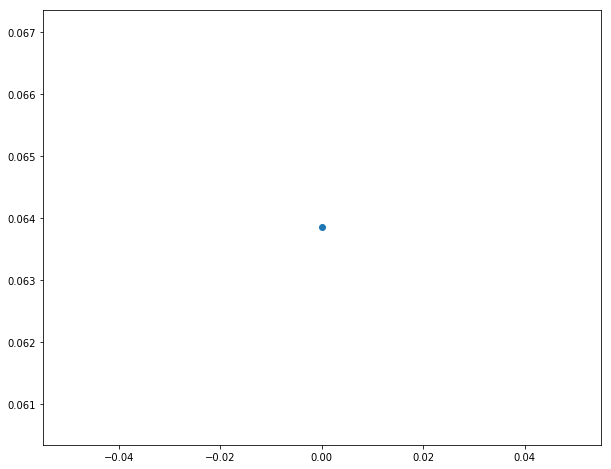

In [40]:
X=np.arange(n_iters)
plt.plot(X, W1_vals, '-o', label='W1')
plt.show()


## Inline Question 2: 
Did you notice anything about the comparative difficulty of training the three-layer net vs training the five layer net? In particular, based on your experience, which network seemed more sensitive to the initialization scale? Why do you think that is the case?

## Answer:
The 5-layer is harder to train.  Harder to initialize.  Probably b/c a more complex model takes more caution to use properly; by definition, it's more complex.


# Update rules
So far we have used vanilla stochastic gradient descent (SGD) as our update rule. More sophisticated update rules can make it easier to train deep networks. We will implement a few of the most commonly used update rules and compare them to vanilla SGD.

# SGD+Momentum
Stochastic gradient descent with momentum is a widely used update rule that tends to make deep networks converge faster than vanilla stochastic gradient descent. See the Momentum Update section at http://cs231n.github.io/neural-networks-3/#sgd for more information.

Open the file `cs231n/optim.py` and read the documentation at the top of the file to make sure you understand the API. Implement the SGD+momentum update rule in the function `sgd_momentum` and run the following to check your implementation. You should see errors less than e-8.

In [41]:
from cs231n.optim import sgd_momentum

N, D  = 4, 5
w     = np.linspace(-0.4, 0.6, num=N*D).reshape(N, D)
dw    = np.linspace(-0.6, 0.4, num=N*D).reshape(N, D)
v     = np.linspace(0.6, 0.9, num=N*D).reshape(N, D)

config= {'learning_rate': 1e-3, 'velocity': v}
next_w, _ = sgd_momentum(w, dw, config=config)

expected_next_w = np.asarray([
  [ 0.1406,      0.20738947,  0.27417895,  0.34096842,  0.40775789],
  [ 0.47454737,  0.54133684,  0.60812632,  0.67491579,  0.74170526],
  [ 0.80849474,  0.87528421,  0.94207368,  1.00886316,  1.07565263],
  [ 1.14244211,  1.20923158,  1.27602105,  1.34281053,  1.4096    ]])
expected_velocity = np.asarray([
  [ 0.5406,      0.55475789,  0.56891579, 0.58307368,  0.59723158],
  [ 0.61138947,  0.62554737,  0.63970526,  0.65386316,  0.66802105],
  [ 0.68217895,  0.69633684,  0.71049474,  0.72465263,  0.73881053],
  [ 0.75296842,  0.76712632,  0.78128421,  0.79544211,  0.8096    ]])

# Should see relative errors around e-8 or less
print('next_w error: ', rel_error(next_w, expected_next_w))
print('velocity error: ', rel_error(expected_velocity, config['velocity']))

next_w error:  8.882347033505819e-09
velocity error:  4.269287743278663e-09


Once you have done so, run the following to train a six-layer network with both SGD and SGD+momentum. You should see the SGD+momentum update rule converge faster.

running with  sgd
(Iteration 1 / 200) loss: 2.707120
(Epoch 0 / 5) train acc: 0.113000; val_acc: 0.104000
(Iteration 11 / 200) loss: 2.334126
(Iteration 21 / 200) loss: 2.222264
(Iteration 31 / 200) loss: 2.146382
(Epoch 1 / 5) train acc: 0.243000; val_acc: 0.189000
(Iteration 41 / 200) loss: 2.189191
(Iteration 51 / 200) loss: 2.140551
(Iteration 61 / 200) loss: 2.139546
(Iteration 71 / 200) loss: 2.060645
(Epoch 2 / 5) train acc: 0.247000; val_acc: 0.216000
(Iteration 81 / 200) loss: 2.033094
(Iteration 91 / 200) loss: 1.979252
(Iteration 101 / 200) loss: 1.936710
(Iteration 111 / 200) loss: 1.935751
(Epoch 3 / 5) train acc: 0.290000; val_acc: 0.247000
(Iteration 121 / 200) loss: 1.957282
(Iteration 131 / 200) loss: 1.914442
(Iteration 141 / 200) loss: 1.973855
(Iteration 151 / 200) loss: 1.873624
(Epoch 4 / 5) train acc: 0.334000; val_acc: 0.276000
(Iteration 161 / 200) loss: 1.941867
(Iteration 171 / 200) loss: 2.002869
(Iteration 181 / 200) loss: 1.915240
(Iteration 191 / 200) los

/usr/local/lib/python3.5/dist-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


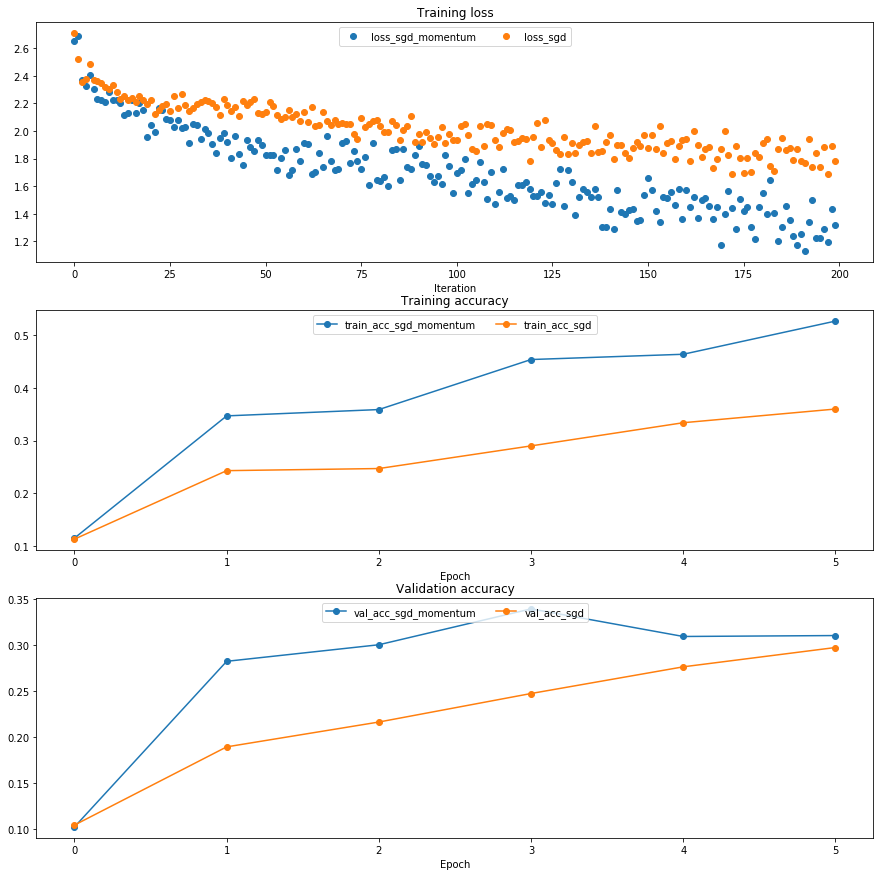

In [42]:
num_train = 4000
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

solvers = {}

for update_rule in ['sgd', 'sgd_momentum']:
  print('running with ', update_rule)
  model = FullyConnectedNet([100, 100, 100, 100, 100], weight_scale=5e-2)

  solver = Solver(model, small_data,
                  num_epochs=5, batch_size=100,
                  update_rule=update_rule,
                  optim_config={
                    'learning_rate': 5e-3,
                  },
                  verbose=True)
  solvers[update_rule] = solver
  solver.train()
  print()

plt.subplot(3, 1, 1)
plt.title('Training loss')
plt.xlabel('Iteration')

plt.subplot(3, 1, 2)
plt.title('Training accuracy')
plt.xlabel('Epoch')

plt.subplot(3, 1, 3)
plt.title('Validation accuracy')
plt.xlabel('Epoch')

for update_rule, solver in solvers.items():
  plt.subplot(3, 1, 1)
  plt.plot(solver.loss_history, 'o', label="loss_%s" % update_rule)
  
  plt.subplot(3, 1, 2)
  plt.plot(solver.train_acc_history, '-o', label="train_acc_%s" % update_rule)

  plt.subplot(3, 1, 3)
  plt.plot(solver.val_acc_history, '-o', label="val_acc_%s" % update_rule)
  
for i in [1, 2, 3]:
  plt.subplot(3, 1, i)
  plt.legend(loc='upper center', ncol=4)
plt.gcf().set_size_inches(15, 15)
plt.show()

# RMSProp and Adam
RMSProp [1] and Adam [2] are update rules that set per-parameter learning rates by using a running average of the second moments of gradients.

In the file `cs231n/optim.py`, implement the RMSProp update rule in the `rmsprop` function and implement the Adam update rule in the `adam` function, and check your implementations using the tests below.

**NOTE:** Please implement the _complete_ Adam update rule (with the bias correction mechanism), not the first simplified version mentioned in the course notes. 

[1] Tijmen Tieleman and Geoffrey Hinton. "Lecture 6.5-rmsprop: Divide the gradient by a running average of its recent magnitude." COURSERA: Neural Networks for Machine Learning 4 (2012).

[2] Diederik Kingma and Jimmy Ba, "Adam: A Method for Stochastic Optimization", ICLR 2015.

In [43]:
# Test RMSProp implementation
from cs231n.optim import rmsprop

N, D = 4, 5
w = np.linspace(-0.4, 0.6, num=N*D).reshape(N, D)
dw = np.linspace(-0.6, 0.4, num=N*D).reshape(N, D)
cache = np.linspace(0.6, 0.9, num=N*D).reshape(N, D)

config = {'learning_rate': 1e-2, 'cache': cache}
next_w, _ = rmsprop(w, dw, config=config)

expected_next_w = np.asarray([
  [-0.39223849, -0.34037513, -0.28849239, -0.23659121, -0.18467247],
  [-0.132737,   -0.08078555, -0.02881884,  0.02316247,  0.07515774],
  [ 0.12716641,  0.17918792,  0.23122175,  0.28326742,  0.33532447],
  [ 0.38739248,  0.43947102,  0.49155973,  0.54365823,  0.59576619]])
expected_cache = np.asarray([
  [ 0.5976,      0.6126277,   0.6277108,   0.64284931,  0.65804321],
  [ 0.67329252,  0.68859723,  0.70395734,  0.71937285,  0.73484377],
  [ 0.75037008,  0.7659518,   0.78158892,  0.79728144,  0.81302936],
  [ 0.82883269,  0.84469141,  0.86060554,  0.87657507,  0.8926    ]])

# You should see relative errors around e-7 or less
print('next_w error: ', rel_error(expected_next_w, next_w))
print('cache error: ', rel_error(expected_cache, config['cache']))

next_w error:  9.524687511038133e-08
cache error:  2.6477955807156126e-09


In [44]:
# Test Adam implementation
from cs231n.optim import adam

N, D = 4, 5
w = np.linspace(-0.4, 0.6, num=N*D).reshape(N, D)
dw = np.linspace(-0.6, 0.4, num=N*D).reshape(N, D)
m = np.linspace(0.6, 0.9, num=N*D).reshape(N, D)
v = np.linspace(0.7, 0.5, num=N*D).reshape(N, D)

config = {'learning_rate': 1e-2, 'm': m, 'v': v, 't': 5}
next_w, _ = adam(w, dw, config=config)

expected_next_w = np.asarray([
  [-0.40094747, -0.34836187, -0.29577703, -0.24319299, -0.19060977],
  [-0.1380274,  -0.08544591, -0.03286534,  0.01971428,  0.0722929],
  [ 0.1248705,   0.17744702,  0.23002243,  0.28259667,  0.33516969],
  [ 0.38774145,  0.44031188,  0.49288093,  0.54544852,  0.59801459]])
expected_v = np.asarray([
  [ 0.69966,     0.68908382,  0.67851319,  0.66794809,  0.65738853,],
  [ 0.64683452,  0.63628604,  0.6257431,   0.61520571,  0.60467385,],
  [ 0.59414753,  0.58362676,  0.57311152,  0.56260183,  0.55209767,],
  [ 0.54159906,  0.53110598,  0.52061845,  0.51013645,  0.49966,   ]])
expected_m = np.asarray([
  [ 0.48,        0.49947368,  0.51894737,  0.53842105,  0.55789474],
  [ 0.57736842,  0.59684211,  0.61631579,  0.63578947,  0.65526316],
  [ 0.67473684,  0.69421053,  0.71368421,  0.73315789,  0.75263158],
  [ 0.77210526,  0.79157895,  0.81105263,  0.83052632,  0.85      ]])

# You should see relative errors around e-7 or less
print('next_w error: ', rel_error(expected_next_w, next_w))
print('v error: ', rel_error(expected_v, config['v']))
print('m error: ', rel_error(expected_m, config['m']))

next_w error:  1.1395691798535431e-07
v error:  4.208314038113071e-09
m error:  4.214963193114416e-09


Once you have debugged your RMSProp and Adam implementations, run the following to train a pair of deep networks using these new update rules:

In [45]:
learning_rates = {'rmsprop': 1e-4, 'adam': 1e-3}
for update_rule in ['adam', 'rmsprop']:
  print('running with ', update_rule)
  model = FullyConnectedNet([100, 100, 100, 100, 100], weight_scale=5e-2)

  solver = Solver(model, small_data,
                  num_epochs=5, batch_size=100,
                  update_rule=update_rule,
                  optim_config={
                    'learning_rate': learning_rates[update_rule]
                  },
                  verbose=True)
  solvers[update_rule] = solver
  solver.train()
  print()

plt.subplot(3, 1, 1)
plt.title('Training loss')
plt.xlabel('Iteration')

plt.subplot(3, 1, 2)
plt.title('Training accuracy')
plt.xlabel('Epoch')

plt.subplot(3, 1, 3)
plt.title('Validation accuracy')
plt.xlabel('Epoch')

for update_rule, solver in list(solvers.items()):
  plt.subplot(3, 1, 1)
  plt.plot(solver.loss_history, 'o', label=update_rule)
  
  plt.subplot(3, 1, 2)
  plt.plot(solver.train_acc_history, '-o', label=update_rule)

  plt.subplot(3, 1, 3)
  plt.plot(solver.val_acc_history, '-o', label=update_rule)
  
for i in [1, 2, 3]:
  plt.subplot(3, 1, i)
  plt.legend(loc='upper center', ncol=4)
plt.gcf().set_size_inches(15, 15)
plt.show()

running with  adam
(Iteration 1 / 200) loss: 2.603408
(Epoch 0 / 5) train acc: 0.115000; val_acc: 0.101000
(Iteration 11 / 200) loss: 2.090346
(Iteration 21 / 200) loss: 1.952897
(Iteration 31 / 200) loss: 1.928727
(Epoch 1 / 5) train acc: 0.341000; val_acc: 0.311000
(Iteration 41 / 200) loss: 1.664126
(Iteration 51 / 200) loss: 1.639443
(Iteration 61 / 200) loss: 1.683368
(Iteration 71 / 200) loss: 1.450732
(Epoch 2 / 5) train acc: 0.388000; val_acc: 0.325000
(Iteration 81 / 200) loss: 1.624021
(Iteration 91 / 200) loss: 1.608807
(Iteration 101 / 200) loss: 1.511052
(Iteration 111 / 200) loss: 1.445463
(Epoch 3 / 5) train acc: 0.511000; val_acc: 0.368000
(Iteration 121 / 200) loss: 1.388554
(Iteration 131 / 200) loss: 1.177362
(Iteration 141 / 200) loss: 1.564626
(Iteration 151 / 200) loss: 1.382872
(Epoch 4 / 5) train acc: 0.537000; val_acc: 0.373000
(Iteration 161 / 200) loss: 1.276759
(Iteration 171 / 200) loss: 1.479683
(Iteration 181 / 200) loss: 1.382091
(Iteration 191 / 200) lo

## Inline Question 3:

AdaGrad, like Adam, is a per-parameter optimization method that uses the following update rule:

```
cache += dw**2
w += - learning_rate * dw / (np.sqrt(cache) + eps)
```

John notices that when he was training a network with AdaGrad that the updates became very small, and that his network was learning slowly. Using your knowledge of the AdaGrad update rule, why do you think the updates would become very small? Would Adam have the same issue?


## Answer: 
Toward the end of the training, the cache becomes very big, bringing learning to a halt.  No, neither AdaM nor RMSProp has this AdaGrad issue because their second order terms decay.

It may be clearer in code (I use the simpler code that doesn't take the unbiased estimated m and v for simplicity):
```
# Adam:
def adam_update(x, dx):
  v = beta2*v + (1-beta2)*(dx**2)  # <=== we "forget" old second-order values at a rate of beta2
  x += - learning_rate * m / (np.sqrt(v) + eps)



```


# Train a good model!
Train the best fully-connected model that you can on CIFAR-10, storing your best model in the `best_model` variable. We require you to get at least 50% accuracy on the validation set using a fully-connected net.

If you are careful it should be possible to get accuracies above 55%, but we don't require it for this part and won't assign extra credit for doing so. Later in the assignment we will ask you to train the best convolutional network that you can on CIFAR-10, and we would prefer that you spend your effort working on convolutional nets rather than fully-connected nets.

You might find it useful to complete the `BatchNormalization.ipynb` and `Dropout.ipynb` notebooks before completing this part, since those techniques can help you train powerful models.

In [46]:
data.keys()

dict_keys(['y_train', 'y_test', 'X_train', 'X_test', 'y_val', 'X_val'])

In [47]:
best_model = None
################################################################################
# TODO: Train the best FullyConnectedNet that you can on CIFAR-10. You might   #
# find batch/layer normalization and dropout useful. Store your best model in  #
# the best_model variable.                                                     #
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

# TODO: Use a five-layer Net to overfit 50 training examples by 
# tweaking just the learning rate and initialization scale.

bs    = 100
epochs=  10
ws    = weight_scale  = 3.872881e-02  #9e-2  # Experiment with this!
lr    = learning_rate = 1.956705e-03  #5e-3  # Experiment with this!             # was 1e-4 initially.  1e-3 made the loss at least go down.  1e-2 got us to 100% training accuracy (0.19 val_acc, though; overfitting)


model = FullyConnectedNet([100, 100, 100, 100],
                weight_scale=weight_scale, dtype=np.float64)
solver = Solver(model, data,
                print_every=100,
                num_epochs=epochs,
                batch_size=bs,
                update_rule='adam',
                optim_config={
                  'learning_rate': lr,
                    'beta1': 0.9,
                    'beta2': 0.999,
                    'epsilon': 1e-8
                }
         )
solver.train()


# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
################################################################################
#                              END OF YOUR CODE                                #
################################################################################

(Iteration 1 / 4900) loss: 2.473590
(Epoch 0 / 10) train acc: 0.144000; val_acc: 0.137000
(Iteration 101 / 4900) loss: 1.816679
(Iteration 201 / 4900) loss: 1.817599
(Iteration 301 / 4900) loss: 1.712773
(Iteration 401 / 4900) loss: 1.659888
(Epoch 1 / 10) train acc: 0.415000; val_acc: 0.432000
(Iteration 501 / 4900) loss: 1.637681
(Iteration 601 / 4900) loss: 1.585427
(Iteration 701 / 4900) loss: 1.818095
(Iteration 801 / 4900) loss: 1.604024
(Iteration 901 / 4900) loss: 1.607087
(Epoch 2 / 10) train acc: 0.443000; val_acc: 0.427000
(Iteration 1001 / 4900) loss: 1.414866
(Iteration 1101 / 4900) loss: 1.498202
(Iteration 1201 / 4900) loss: 1.522560
(Iteration 1301 / 4900) loss: 1.522031
(Iteration 1401 / 4900) loss: 1.649549
(Epoch 3 / 10) train acc: 0.448000; val_acc: 0.460000
(Iteration 1501 / 4900) loss: 1.542974
(Iteration 1601 / 4900) loss: 1.351395
(Iteration 1701 / 4900) loss: 1.325873
(Iteration 1801 / 4900) loss: 1.399408
(Iteration 1901 / 4900) loss: 1.564273
(Epoch 4 / 10) t

# Test your model!
Run your best model on the validation and test sets. You should achieve above 50% accuracy on the validation set.

In [48]:
best_model=model

In [50]:
dir(best_model)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__slotnames__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'bn_params',
 'debug_info',
 'dropout_param',
 'dtype',
 'loss',
 'normalization',
 'num_layers',
 'params',
 'reg',
 'use_dropout']

In [49]:
y_test_pred = np.argmax(best_model.loss(data['X_test']), axis=1)
y_val_pred = np.argmax(best_model.loss(data['X_val']), axis=1)
print('Validation set accuracy: ', (y_val_pred == data['y_val']).mean())
print('Test set accuracy: ', (y_test_pred == data['y_test']).mean())

Validation set accuracy:  0.498
Test set accuracy:  0.492


In [ ]:
import pickle as pkl
pkl_fname="5_layer_net___FullyConnectedNets_assn2___lr_is_{0}___and_weight_scale_is_{1}.pkl".format(
  lr)
with open(pkl_fname, "wb") as fp:
    pkl.dump(best_model, fp)

# come back once you've done Dropout() and Batch_norm(), and it should work better.